# The purpose of this is to provide a time-series forecast model to predict if the number of positives a country/territory will receive within the next number of days will increase or decrease

> data from: https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide

In [ ]:
# Import custom Time_Series python library and other imports
%run ./utils_gdrive.ipynb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, TimeDistributed, GRU
from keras.optimizers import Adam
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Set start and end dates for train and test sets

In [ ]:
str_train_start = '01/01/2020'
str_train_end = '11/01/2020'
str_test_start = str_train_end
str_test_end = '12/01/2020'
start_train_date = pd.to_datetime(str_train_start) # start of train data
end_train_date = pd.to_datetime(str_train_end) # end of train data
start_test_date = pd.to_datetime(str_test_start) # start of train data
end_test_date = pd.to_datetime(str_test_end) # end of train data
k = 17 # number of n-day components
n = 5 # n in n-day averages

## Define model evaluations

In [ ]:
models = {} # trained models
Ps_test = {} # post processed predictions
Ts_test = {} # post processed truths

# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    aerror = np.zeros(y_true.shape, dtype=float)
    for i in range(y_true.shape[0]):
        if y_true[i] < 1:
            aerror[i] = y_pred[i]
        else:
            aerror[i] = np.abs((y_true[i] - y_pred[i]) / y_true[i])
    return np.mean(aerror)

# Measure how accurately model predicted if cases increase or decrease
def increase_decrease_accuracy(x_true, y_true, y_pred):
    n_correct = 0
    for i in range(y_true.shape[0]):
        if y_true[i] > x_true[i, -1]:
            if y_pred[i] > x_true[i, -1]:
                n_correct += 1
        elif y_true[i] < x_true[i, -1]:
            if y_pred[i] < x_true[i, -1]:
                n_correct += 1
    return n_correct / y_true.shape[0]

# plot and evalute model predictions
def evaluate(model_name, proc, X_test, Y_test, P_Test):
    r2 = r2_score(Y_test, P_Test)
    rmse = sqrt(mean_squared_error(Y_test, P_Test))
    mae = mean_absolute_error(Y_test, P_Test)
    mape = mean_absolute_percentage_error(Y_test, P_Test)
    ida = increase_decrease_accuracy(X_test, Y_test, P_Test)
    plt.scatter(np.log10(P_Test), np.log10(Y_test))
    max_order = int(max(np.log10(Y_test).max(), np.log10(P_Test).max())) + 2
    plt.plot([x for x in range(max_order)], [x for x in range(max_order)], color='green')
    plt.xticks(np.arange(0, max_order, 1))
    plt.yticks(np.arange(0, max_order, 1))
    plt.xlabel(r'log$_{10}$(Predicted)')
    plt.ylabel(r'log$_{10}$(Expected)')
    plt.title(model_name + ' ' + proc.title() + ' ' + r'Forecasts, $r^2$=' + str(round(r2, 4)))
    plt.show()
    print('r2', r2, 'rmse', rmse, 'mae', mae, 'mape', mape, 'ida', ida, '\n\n')

## Read, Mungle, Plot, and Process Data

In [ ]:
# read data
data = readCOVID19('COVID-19-geographic-disbtribution-worldwide-2020-12-11.csv', days_min=100, cases_min=100)

# plot data
#plot5(data)

samples = {}
for_ARIMA = {}
# get trianing data (up to start_date)
samples['train'], for_ARIMA['train_raw'] = prepare_MLA(data, window_size=n, lags=k, sample_name='train'
                            ,outputs=1, label_type='next', deriv=False
                               , start_date=start_train_date, end_date=end_train_date)
# get testing data (between start_date and end_date)
samples['test'], for_ARIMA['test_raw'] = prepare_MLA(data, window_size=n, lags=k, sample_name='test'
                            ,outputs=1, label_type='next', deriv=False
                              , start_date=start_test_date, end_date=end_test_date)

In [ ]:
# get X and Y for train and test
Xs_train = {'raw': np.array(samples['train']['Xs'])}
Ys_train = {'raw' : np.array(samples['train']['Ys']).flatten()}
Xs_test = {'raw' : np.array(samples['test']['Xs'])}
Ys_test = {'raw' : np.array(samples['test']['Ys']).flatten()}

# get statistics on train data
X_min = np.min(Xs_train['raw'])
X_max = np.max(Xs_train['raw'])
X_mean = np.mean(Xs_train['raw'])
X_std = np.std(Xs_train['raw'])

# define methods for forward and backward processing
reverses = {}
def preproc(base, name, func):
    Xs_train[name] = func(Xs_train[base])
    Ys_train[name] = func(Ys_train[base])
    Xs_test[name] = func(Xs_test[base])
    Ys_test[name] = func(Ys_test[base])
    for_ARIMA['train_' + name] = {}
    for country in for_ARIMA['train_' + base]:
        for_ARIMA['train_' + name][country] = func(for_ARIMA['train_' + base][country])
    for_ARIMA['test_' + name] = {}
    for country in for_ARIMA['test_' + base]:
        for_ARIMA['test_' + name][country] = func(for_ARIMA['test_' + base][country])

# raw
def reverse_raw(X):
    return X
reverses['raw'] = reverse_raw

# min max normalize between 0 and 1
def norm(X):
    return (X - X_min) / (X_max - X_min)
preproc('raw', 'norm', norm)
def reverse_norm(X):
    return X * (X_max - X_min) + X_min
reverses['norm'] = reverse_norm

# standardize to zero mean and unit variance 
def stand(X):
    return (X - X_mean) / X_std
preproc('raw', 'stand', stand)
def reverse_stand(X):
    return X * X_std + X_mean
reverses['stand'] = reverse_stand
        
# log10 to consider the large range of values
preproc('raw', 'log10', np.log10)
def reverse_log10(X):
    return np.power(10, X)
reverses['log10'] = reverse_log10

# get statistics on ln train data
X_log10_min = np.min(Xs_train['log10'])
X_log10_max = np.max(Xs_train['log10'])
X_log10_mean = np.mean(Xs_train['log10'])
X_log10_std = np.std(Xs_train['log10'])

# take log10 then min max normalize between 0 and 1
def log10_norm(X):
    retX = np.log10(X)
    return (retX - X_log10_min) / (X_log10_max - X_log10_min)
preproc('raw', 'log10_norm', log10_norm)
def reverse_log10_norm(X):
    retX = X * (X_log10_max - X_log10_min) + X_log10_min
    return np.power(10, retX)
reverses['log10_norm'] = reverse_log10_norm

# take log10 then standardize
def log10_stand(X):
    retX = np.log10(X)
    return (retX - X_log10_mean) / X_log10_std
preproc('raw', 'log10_stand', log10_stand)
def reverse_log10_stand(X):
    retX = X * X_log10_std + X_log10_mean
    return np.power(10, retX)
reverses['log10_stand'] = reverse_log10_stand
        
# ln to consider the large range of values
preproc('raw', 'ln', np.log)
def reverse_ln(X):
    return np.exp(X)
reverses['ln'] = reverse_ln

# get statistics on ln train data
X_ln_min = np.min(Xs_train['ln'])
X_ln_max = np.max(Xs_train['ln'])
X_ln_mean = np.mean(Xs_train['ln'])
X_ln_std = np.std(Xs_train['ln'])

# take ln then min max normalize between 0 and 1
def ln_norm(X):
    retX = np.log(X)
    return (retX - X_ln_min) / (X_ln_max - X_ln_min)
preproc('raw', 'ln_norm', ln_norm)
def reverse_ln_norm(X):
    retX = X * (X_ln_max - X_ln_min) + X_ln_min
    return np.exp(retX)
reverses['ln_norm'] = reverse_ln_norm

# take ln then standardize
def ln_stand(X):
    retX = np.log(X)
    return (retX - X_ln_mean) / X_ln_std
preproc('raw', 'ln_stand', ln_stand)
def reverse_ln_stand(X):
    retX = X * X_ln_std + X_ln_mean
    return np.exp(retX)
reverses['ln_stand'] = reverse_ln_stand

# preprare for RNN by casting X and Y in dimensions [N_samples, N_timesteps, N_features]
procs = ['norm', 'stand', 'log10', 'log10_norm', 'log10_stand', 'ln', 'ln_norm', 'ln_stand', 'raw']
for proc in procs:
    Xs_train[proc + '_rnn'] = np.expand_dims(Xs_train[proc], axis=2)
    Ys_train[proc + '_rnn'] = np.expand_dims(np.expand_dims(Ys_train[proc], axis=1), axis=2)
    Xs_test[proc + '_rnn'] = np.expand_dims(Xs_test[proc], axis=2)
    Ys_test[proc + '_rnn'] = np.expand_dims(np.expand_dims(Ys_test[proc], axis=1), axis=2)

# post_process model predictions by undoing processing and removing <1 values
def post_process(X, Y, P, proc):
    P = reverses[proc](P)
    drop_rows = [r for r in range(P.shape[0]) if P[r] <= 1]
    return np.delete(X, drop_rows, axis=0), np.delete(Y, drop_rows, axis=0), np.delete(P, drop_rows, axis=0)

## Bi-LSTM

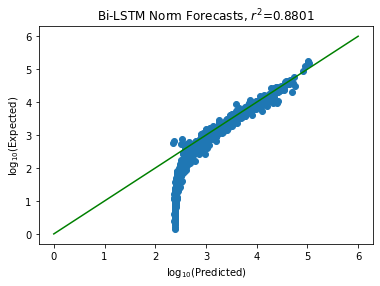

r2 0.8800538809112 rmse 4849.526032374051 mae 1074.2585995817587 mape 5.351843704345777 ida 0.5812274368231047 




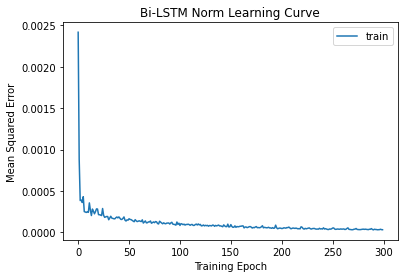

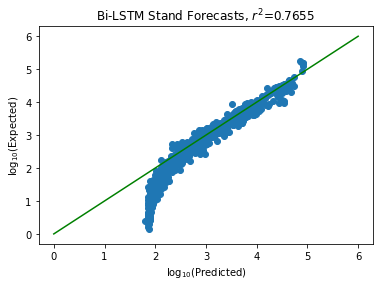

r2 0.7654771462486963 rmse 6781.07862113897 mae 1312.0345614546902 mape 1.7524888042833484 ida 0.5643802647412756 




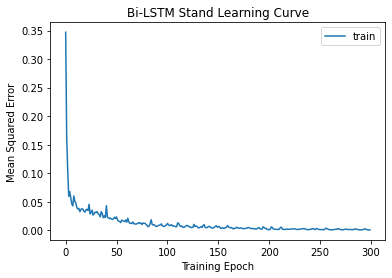

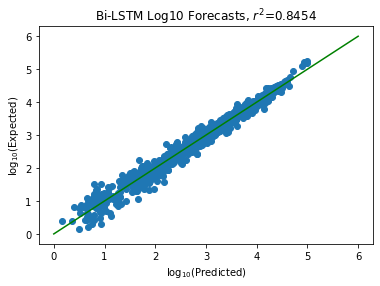

r2 0.8453908193860988 rmse 5505.843134612195 mae 1000.1489935996301 mape 0.30055089775024135 ida 0.5367027677496992 




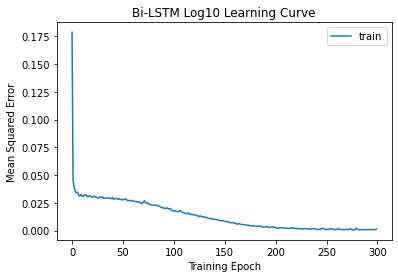

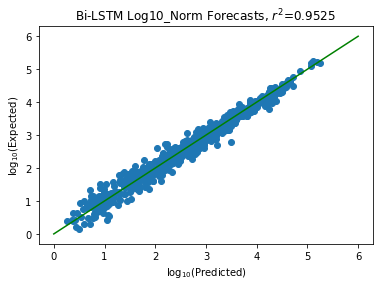

r2 0.9525065224078535 rmse 3051.5688993508875 mae 785.7356623084968 mape 0.30877452751349477 ida 0.5728038507821901 




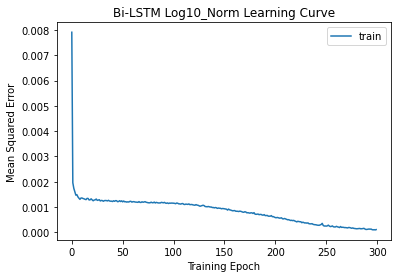

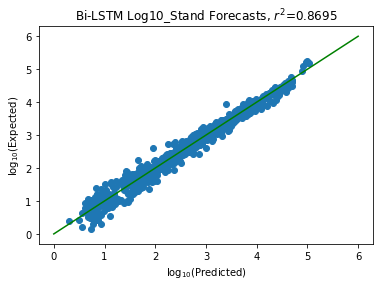

r2 0.8695166322323465 rmse 5058.0576299521435 mae 977.0164931025888 mape 0.29530748607930934 ida 0.5643802647412756 




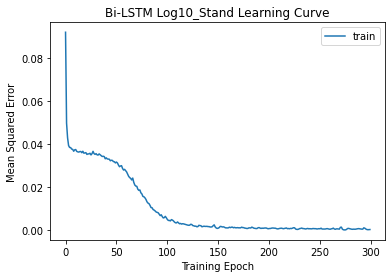

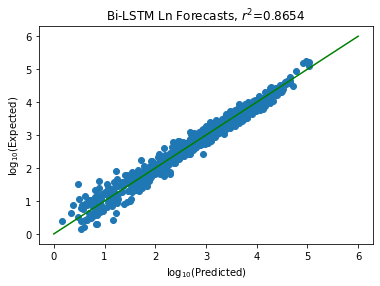

r2 0.8653626201610299 rmse 5137.93990437373 mae 1011.5826176467785 mape 0.3048670255312469 ida 0.5391095066185319 




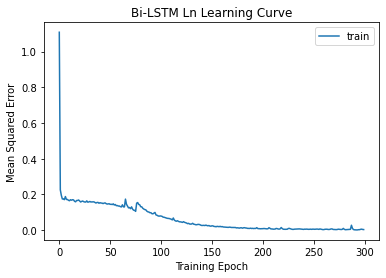

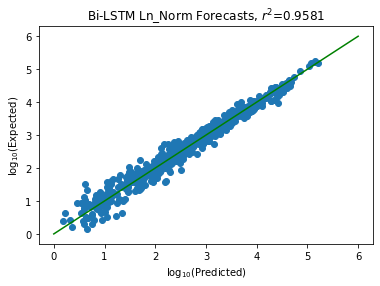

r2 0.9581345415890966 rmse 2865.0626302003357 mae 764.3431357121494 mape 0.2930112046921105 ida 0.5836341756919374 




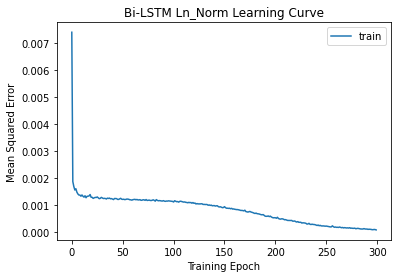

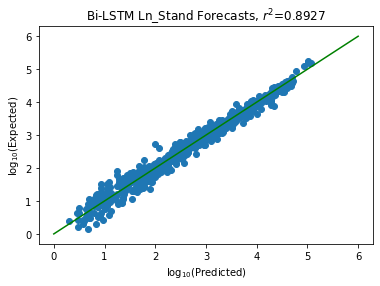

r2 0.8926894116541414 rmse 4586.986717890302 mae 941.1334497819882 mape 0.2853288164059204 ida 0.5836341756919374 




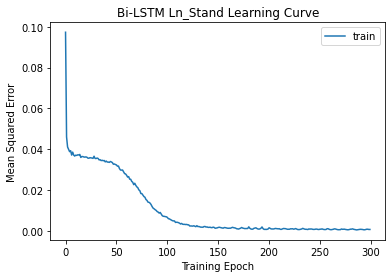

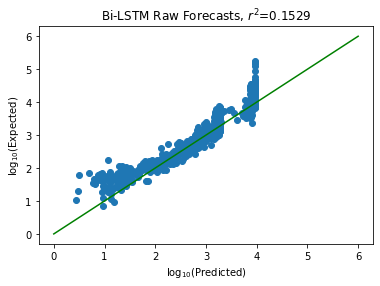

r2 0.15288241986930462 rmse 13686.222949346706 mae 2913.0242672862587 mape 0.3684852367553855 ida 0.49175824175824173 




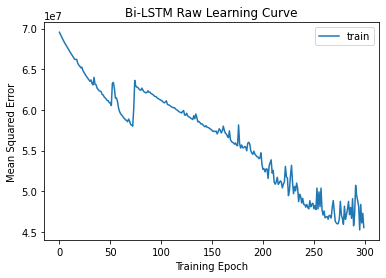

In [ ]:
#### Bi-LSTM taking variable sequence length
model_name = 'Bi-LSTM'

for proc in procs:
    
    # ceate model
    model = Sequential()
    model.add(Bidirectional(LSTM(32, return_sequences=True, input_shape=(None, 1), use_bias=False)))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dense(1))
    # add optimizer
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mae'])
    # train 
    history = model.fit(Xs_train[proc + '_rnn'], Ys_train[proc + '_rnn']
                                                  , epochs=300, batch_size=10, verbose=0)
    
    # get predictions and post process
    returns = post_process(
        Xs_test['raw']
        , Ys_test['raw']
        , model.predict(Xs_test[proc + '_rnn']).flatten()
        , proc
    )
    X_test = returns[0]
    T_test = returns[1]
    P_test = returns[2]
    
    # evaluate model
    evaluate(
        model_name
        , proc
        , X_test
        , T_test
        , P_test
    )

    # plot learning curve
    plt.plot(history.history['loss'], label='train')
    plt.ylabel('Mean Squared Error')
    plt.xlabel('Training Epoch')
    plt.title(model_name + ' ' + proc.title() + ' Learning Curve')
    plt.legend()
    plt.show()